# Purpose
* [Naive Bayes model with PyMC3](https://discourse.pymc.io/t/naive-bayes-model-with-pymc3/2314)
* [PyMC Tutorial #2: Estimating the Parameters of A Naïve Bayes (NB) Model ](http://alfan-farizki.blogspot.com/2015/07/pymc-tutorial-2-estimating-parameters.html)
* [PyMC3 Models NaiveBayes](https://pymc3-models.readthedocs.io/en/latest/api/pymc3_models.models.html#module-pymc3_models.models.NaiveBayes)
    - To learn more, you can read this section, watch a [video from PyData NYC 2017](https://www.youtube.com/watch?v=zGRnirbHWJ8), or check out the [slides](https://github.com/parsing-science/pydata_nyc_nov_2017).
    - [Example Notebook](https://pymc3-models.readthedocs.io/en/latest/examples.html)
* [(Bayesian) Naive Bayes algorithm](https://nbviewer.jupyter.org/github/parsing-science/pymc3_models/blob/master/notebooks/NaiveBayes.ipynb)
* [Probabilistic Graphical Models](https://cs.brown.edu/courses/csci2950-p/lectures/2013-04-25_crfMaxProduct.pdf)
* [Bayesian Naive Bayes, aka Dirichlet-Multinomial Classifiers](https://lingpipe-blog.com/2009/10/02/bayesian-naive-bayes-aka-dirichlet-multinomial-classifiers/)
* [1.3. Naive Bayes](https://pymc-learn.readthedocs.io/en/latest/modules/naive_bayes.html#naive-bayes)
* [ML in Python: Naive Bayes the hard way](https://healthyalgorithms.com/2013/04/13/ml-in-python-naive-bayes-the-hard-way/)
    - [Notebook - really inefficient version of the Naive Bayes classifier](https://nbviewer.ipython.org/gist/anonymous/5380476)
* [Bayesian Methods (Lab)](https://davidrosenberg.github.io/mlcourse/Archive/2015/Lectures/12.Lab.bayesian-methods.pdf)
    - Source from [mlcourse by David Rosenberg](https://github.com/davidrosenberg/mlcourse)
* [How to specify the prior probability for scikit-learn's Naive Bayes](https://stackoverflow.com/questions/30896367/how-to-specify-the-prior-probability-for-scikit-learns-naive-bayes)
* [Naive Bayesian](https://saedsayad.com/naive_bayesian.htm)

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

In [2]:
key = jax.random.PRNGKey(0)
key

DeviceArray([0, 0], dtype=uint32)

In [3]:
keys = jax.random.split(key, 2)
d_X = dist.Bernoulli(jnp.array((0.91, 0.02, 0.90, 0.32, 0.66, 0.71, 0.32, 0.70, 0.94, 0.49)))
d_y = dist.Bernoulli(jnp.array((0.8)))
X = d_X.sample(keys[0], (300,))
y = d_y.sample(keys[1], (300,))

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
X_train

DeviceArray([[1, 0, 0, ..., 1, 1, 0],
             [1, 0, 1, ..., 1, 1, 0],
             [1, 0, 1, ..., 1, 1, 0],
             ...,
             [1, 0, 1, ..., 1, 1, 0],
             [0, 0, 1, ..., 0, 1, 1],
             [1, 0, 1, ..., 1, 1, 1]], dtype=int32)

In [7]:
X_train.shape, y_train.shape

((201, 10), (201,))

In [8]:
def model(X, num_classes, y=None,):
    num_items, num_features = X.shape
    pi = numpyro.sample("pi", dist.Dirichlet(jnp.ones(num_classes)))
    
    with numpyro.plate("D", num_features, dim=None):
        with numpyro.plate("C", num_classes):
            theta = numpyro.sample("theta", dist.Beta(1,1))
            
    with numpyro.plate("N", num_items, dim=-2):
        y = numpyro.sample("y", dist.Categorical(pi), obs=y)
        with numpyro.plate("D", num_features, dim=None):
            x = numpyro.sample("x", dist.Bernoulli(theta[y]), obs=X)

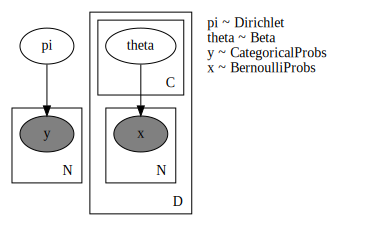

In [9]:
numpyro.render_model(model, (X_train[:10,:], 2, y_train[:10]), render_distributions=True)

In [10]:
jnp.array((0.91, 0.02, 0.90, 0.32, 0.66, 0.71, 0.32, 0.70, 0.94, 0.49))

DeviceArray([0.91, 0.02, 0.9 , 0.32, 0.66, 0.71, 0.32, 0.7 , 0.94, 0.49],            dtype=float32)

In [11]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=4)
mcmc.run(key, X_train, 2, y_train, extra_fields=("potential_energy",))
mcmc.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:02<00:00, 542.36it/s, 7 steps of size 5.07e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     pi[0]      0.13      0.00      0.13      0.13      0.14   9885.67      1.00
     pi[1]      0.87      0.00      0.87      0.86      0.87   9889.57      1.00
theta[0,0]      0.79      0.07      0.80      0.68      0.91   8178.04      1.00
theta[0,1]      0.07      0.05      0.06      0.01      0.13   6390.77      1.00
theta[0,2]      0.93      0.05      0.94      0.87      1.00   6495.42      1.00
theta[0,3]      0.34      0.09      0.34      0.21      0.50   7260.45      1.00
theta[0,4]      0.69      0.09      0.69      0.56      0.84   8179.59      1.00
theta[0,5]      0.62      0.09      0.62      0.47      0.76   7706.05      1.00
theta[0,6]      0.24      0.08      0.24      0.12      0.37   7391.11      1.00
theta[0,7]      0.52      0.09      0.52      0.37      0.67   6011.63      1.00
theta[0,8]      0.86      0.06      0.87      0.77      0.97   6242.76      1.00
theta[0,9]      0.59      0

In [12]:
ds = az.from_numpyro(mcmc)

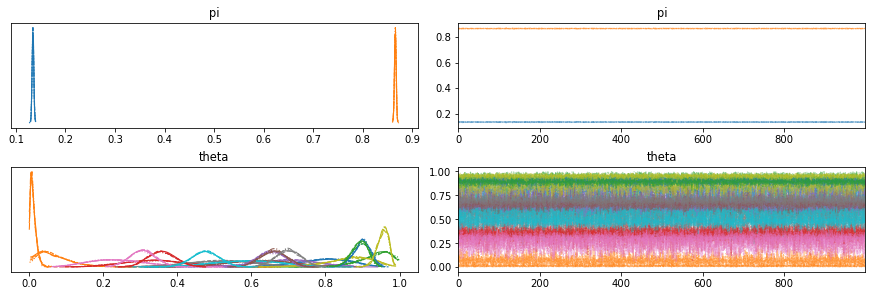

In [13]:
az.plot_trace(ds);

In [14]:
from numpyro.infer import Predictive

In [15]:
predictive = Predictive(model, mcmc.get_samples())

In [16]:
predictions = predictive(jax.random.PRNGKey(3), X_test, 2)['y']

In [17]:
X_test.shape

(99, 10)

In [18]:
predictions.shape

(4000, 99, 1)

In [19]:
predictions.squeeze().mean()

DeviceArray(0.8656389, dtype=float32)

In [20]:
clf = BernoulliNB(alpha=1)

In [21]:
clf.fit(X_train, y_train)

BernoulliNB(alpha=1)

In [22]:
clf.class_count_ / clf.class_count_.sum()

array([0.13432836, 0.86567164])

In [23]:
(clf.feature_count_ / clf.feature_count_.sum()).T

array([[0.01858108, 0.13260135],
       [0.00084459, 0.00084459],
       [0.02195946, 0.13175676],
       [0.00760135, 0.05236486],
       [0.0160473 , 0.09628378],
       [0.01435811, 0.09712838],
       [0.00506757, 0.04476351],
       [0.01182432, 0.10304054],
       [0.02027027, 0.1410473 ],
       [0.01351351, 0.07010135]])

In [24]:
clf.score(X_test, y_test)

0.7373737373737373